In [3]:

!git clone https://github.com/Kiyong314/Cancel_Detect_Tensorflow_Project.git /content/Cancel_Detect_Tensorflow_Project

import shutil
import os

source_folder = '/content/Cancel_Detect_Tensorflow_Project/The IQ-OTHNCCD lung cancer dataset'
destination_folder = '/content/The IQ-OTHNCCD lung cancer dataset'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate over all files and subfolders in the source folder
for item in os.listdir(source_folder):
    s = os.path.join(source_folder, item)
    d = os.path.join(destination_folder, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, symlinks=False, ignore=None)
    else:
        shutil.copy2(s, d)

print(f"Contents of '{source_folder}' have been copied to '{destination_folder}'.")


Cloning into '/content/Cancel_Detect_Tensorflow_Project'...
remote: Enumerating objects: 6439, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6439 (delta 0), reused 0 (delta 0), pack-reused 6437 (from 1)
Receiving objects: 100% (6439/6439), 832.57 MiB | 32.32 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Updating files: 100% (4321/4321), done.
Contents of '/content/Cancel_Detect_Tensorflow_Project/The IQ-OTHNCCD lung cancer dataset' have been copied to '/content/The IQ-OTHNCCD lung cancer dataset'.


In [4]:
# -----------------------------------------------
# 🔧 FocusNet-LC 전체 파이프라인 (Step 1~9 통합 정리)
# -----------------------------------------------

# Step 1️: 라이브러리 불러오기
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Step 2️: 기본 설정 (수동 zip 업로드 방식)
from google.colab import files


# 경로 설정
base_path = "/content/The IQ-OTHNCCD lung cancer dataset"
print("압축 풀린 경로 내부 폴더들:", os.listdir(base_path))

# 클래스별 이미지 개수 확인
for folder_name in ["Normal cases", "Bengin cases", "Malignant cases"]:
    full_path = os.path.join(base_path, folder_name)
    image_files = glob(os.path.join(full_path, "*.jpg"))
    print(f"📸 {folder_name}: {len(image_files)} images")

압축 풀린 경로 내부 폴더들: ['Normal cases', 'IQ-OTH_NCCD lung cancer dataset.txt', 'Malignant cases', 'Bengin cases']
📸 Normal cases: 416 images
📸 Bengin cases: 120 images
📸 Malignant cases: 561 images


 **1. 전처리 코드**

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import time

# 경로 설정
save_path = "/content/lung_preprocessing_results"
labels = ['Normal cases', 'Bengin cases', 'Malignant cases']


def lung_preprocessing(image_path):
    """
    CT 이미지 폐 전처리 함수

    Args:
        image_path: 이미지 경로 (문자열) 또는 이미지 배열

    Returns:
        lung_mask: 폐 영역 마스크 (0-1)
        lung_image: 전처리된 폐 이미지 (0-1)
        original_image: 원본 이미지 (0-1)
    """

    # 이미지 로드
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None, None, None
    else:
        img = image_path

    original_normalized = img.astype(np.float32) / 255.0
    img_height, img_width = original_normalized.shape
    center_x, center_y = img_width // 2, img_height // 2

    # 1. 몸통 추출
    img_hu_approx = (original_normalized * 2000) - 1000
    body_mask = img_hu_approx > -100

    kernel = np.ones((5, 5), np.uint8)
    body_mask = cv2.morphologyEx(body_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    # 몸통 선택 (중앙에 가장 가까운 큰 영역)
    contours, _ = cv2.findContours(body_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        min_body_area = body_mask.size * 0.15
        max_body_area = body_mask.size * 0.8

        best_contour = None
        min_distance = float('inf')

        for contour in contours:
            area = cv2.contourArea(contour)
            if min_body_area <= area <= max_body_area:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    distance = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)

                    if distance < min_distance:
                        min_distance = distance
                        best_contour = contour

        if best_contour is not None:
            body_mask = np.zeros_like(body_mask)
            cv2.fillPoly(body_mask, [best_contour], 1)
        else:
            return None, None, None
    else:
        return None, None, None

    # 2. 베드 영역 제거
    bed_mask = np.zeros_like(body_mask, dtype=bool)

    # 하단 10%, 좌우 8% 제거
    bottom_region = int(img_height * 0.10)
    side_margin = int(img_width * 0.08)
    bed_mask[-bottom_region:, :] = True
    bed_mask[:, :side_margin] = True
    bed_mask[:, -side_margin:] = True

    # 몸통 외부 어두운 영역 제거
    expanded_body = cv2.dilate(body_mask, np.ones((15, 15), np.uint8), iterations=2)
    outside_body = ~expanded_body.astype(bool)
    dark_areas = original_normalized < 0.1
    bed_mask = bed_mask | (outside_body & dark_areas)

    # 3. 하얀 조직 및 혈관 제거
    enhanced = np.clip(original_normalized * 1.2 + 0.1, 0, 1)
    white_mask = (enhanced * body_mask) > 0.75

    # 🆕 혈관/염증 영역 제거 (너무 밝은 부분)
    vessel_mask = (original_normalized > 0.7) & body_mask.astype(bool)

    # 폐 영역 마스크 생성 (더 엄격한 밝기 범위)
    intensity_mask = (original_normalized >= 0.18) & (original_normalized <= 0.55)
    lung_mask = body_mask.astype(bool) & ~white_mask & ~bed_mask & ~vessel_mask & intensity_mask

    # 4. 몸통 경계 수축
    eroded_body = cv2.erode(body_mask, np.ones((7, 7), np.uint8), iterations=2)
    lung_mask = lung_mask & eroded_body.astype(bool)

    # 5. 폐 영역 선택 (화면 3등분 기준으로 좌우선에서 가까운 순서로 선택)
    contours, _ = cv2.findContours(lung_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_mask = np.zeros_like(lung_mask, dtype=np.uint8)
    body_area = np.sum(body_mask)
    min_area = body_area * 0.005
    max_area = body_area * 0.35

    # 화면을 세등분: 좌측선(1/3), 우측선(2/3)
    left_line = img_width / 3
    right_line = img_width * 2 / 3

    # 유효한 폐 영역 찾기
    valid_regions = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # 위치 검증
                if (cy < img_height * 0.7 and
                    img_width * 0.15 < cx < img_width * 0.85):

                    # 좌측선과 우측선으로부터의 거리 계산
                    dist_to_left_line = abs(cx - left_line)
                    dist_to_right_line = abs(cx - right_line)
                    min_dist_to_lines = min(dist_to_left_line, dist_to_right_line)

                    # 좌측/우측 구분
                    is_left_region = cx < center_x

                    valid_regions.append((contour, area, cx, cy, min_dist_to_lines, is_left_region))

    # 좌우선에 가까운 순서로 정렬
    valid_regions.sort(key=lambda x: x[4])  # min_dist_to_lines 기준으로 정렬

    # 좌우 폐 선택
    selected = []
    left_selected = False
    right_selected = False

    for region in valid_regions:
        contour, area, cx, cy, dist_to_lines, is_left = region

        # 좌측 영역 선택
        if is_left and not left_selected:
            selected.append(region)
            left_selected = True
        # 우측 영역 선택
        elif not is_left and not right_selected:
            selected.append(region)
            right_selected = True

        # 좌우 모두 선택되면 종료
        if left_selected and right_selected:
            break

    # 좌우 중 하나만 선택된 경우, 추가로 하나 더 선택 시도
    if len(selected) == 1:
        selected_side = selected[0][5]  # 이미 선택된 쪽이 좌측인지 우측인지
        selected_cx = selected[0][2]
        selected_area = selected[0][1]

        # 반대편에서 가장 가까운 영역 찾기
        for i, region in enumerate(valid_regions):
            # 좌표와 면적으로 중복 확인
            is_already_selected = any(selected_cx == s[2] and selected_area == s[1] for s in selected)

            if not is_already_selected and region[5] != selected_side:
                # 면적 비율 검증
                area_ratio = min(selected_area, region[1]) / max(selected_area, region[1])
                if area_ratio > 0.15:  # 면적 비율이 합리적인 경우만
                    selected.append(region)
                    break

    # 아직도 하나만 선택된 경우, 같은 쪽에서라도 추가 선택
    if len(selected) == 1:
        selected_cx = selected[0][2]
        selected_area = selected[0][1]

        for i, region in enumerate(valid_regions):
            # 좌표와 면적으로 중복 확인
            is_already_selected = any(selected_cx == s[2] and selected_area == s[1] for s in selected)

            if not is_already_selected:
                # 거리 검증 (너무 가깝지 않은 경우만)
                cx_diff = abs(selected_cx - region[2])
                if cx_diff > img_width * 0.1:
                    area_ratio = min(selected_area, region[1]) / max(selected_area, region[1])
                    if area_ratio > 0.15:
                        selected.append(region)
                        break

    # 선택된 영역이 없는 경우, 면적이 가장 큰 두 영역 선택
    if len(selected) == 0 and len(valid_regions) > 0:
        # 면적 순으로 정렬
        valid_regions.sort(key=lambda x: x[1], reverse=True)
        selected = valid_regions[:min(2, len(valid_regions))]

    # 선택된 영역 마스크에 추가
    for region in selected:
        cv2.fillPoly(final_mask, [region[0]], 1)

    # 추가: 세밀한 폐 내부 채우기 기능
    if selected:  # 선택된 영역이 있을 때만 채우기 수행

        # 1. 작은 구멍만 채우기 (보수적 접근)
        small_fill_kernel = np.ones((3, 3), np.uint8)
        filled_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, small_fill_kernel, iterations=2)

        # 2. 선택적 내부 채우기 (컨벡스 헐 대신 제한적 확장)
        def selective_fill(mask, original_img, body_mask):
            """폐 조직 영역만 선별적으로 채우기"""
            result = mask.copy()

            # 폐 조직 같은 밝기 영역 찾기 (기존 폐 마스크 주변)
            lung_intensity_min = 0.15
            lung_intensity_max = 0.6

            # 기존 폐 영역 확장
            expand_kernel = np.ones((3, 3), np.uint8)
            expanded = cv2.dilate(mask, expand_kernel, iterations=2)

            # 확장된 영역 중에서 폐 조직 밝기에 해당하는 부분만 선택
            lung_like_areas = (original_img >= lung_intensity_min) & (original_img <= lung_intensity_max)
            valid_expansion = expanded & body_mask.astype(np.uint8) & lung_like_areas.astype(np.uint8)

            # 뼈/혈관 영역 제외 (더 엄격하게)
            exclude_bright = original_img > 0.7  # 밝은 혈관/뼈
            exclude_very_dark = original_img < 0.12  # 너무 어두운 공기

            valid_expansion = valid_expansion & ~exclude_bright.astype(np.uint8) & ~exclude_very_dark.astype(np.uint8)

            return valid_expansion

        # 선별적 채우기 적용
        filled_mask = selective_fill(filled_mask, original_normalized, body_mask)

        # 3. 형태학적 정리 (부드럽게)
        smooth_kernel = np.ones((2, 2), np.uint8)
        filled_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_CLOSE, smooth_kernel, iterations=1)

        # 4. 원본 영역과 결합 (기존 + 새로 채운 부분)
        # 기존 영역은 보존하고 새로 채운 부분만 추가
        final_filled = final_mask | filled_mask

        # 5. 최종 안전 체크 - 너무 커지지 않도록 제한
        contours_check, _ = cv2.findContours(final_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        checked_mask = np.zeros_like(final_filled)

        for contour in contours_check:
            area = cv2.contourArea(contour)
            # 면적이 너무 크지 않은 경우만 허용 (몸통의 40% 이하)
            if min_area <= area <= body_area * 0.4:
                cv2.fillPoly(checked_mask, [contour], 1)

        # 최종 마스크 적용
        final_mask = checked_mask

    # 최종 결과
    lung_mask_final = final_mask.astype(bool)
    lung_image = original_normalized * lung_mask_final

    return lung_mask_final, lung_image, original_normalized

def test_images(num_samples=50, show_all=False):
    """
    이미지 테스트 함수

    Args:
        num_samples: 테스트할 이미지 수
        show_all: True면 모든 결과 표시, False면 처음 50개만 표시
    """

    print(f"🔬 {num_samples}개 이미지 테스트 시작...")

    # 모든 이미지 경로 수집
    all_paths = []

    for label in labels:
        folder_path = os.path.join(base_path, label)
        paths = glob(os.path.join(folder_path, '*.jpg'))
        for path in paths:
            all_paths.append((path, label))

    # 랜덤 샘플 선택
    import random
    random.shuffle(all_paths)
    samples = all_paths[:num_samples]

    # 처리 및 통계
    results = []
    failed = 0
    processing_times = []

    for i, (path, label) in enumerate(samples):
        start_time = time.time()
        lung_mask, lung_img, original = lung_preprocessing(path)
        proc_time = time.time() - start_time
        processing_times.append(proc_time)

        if lung_mask is not None:
            lung_ratio = np.sum(lung_mask) / lung_mask.size
            if 0.003 < lung_ratio < 0.45:  # 더 엄격한 상한선
                results.append((path, label, lung_mask, lung_img, original, lung_ratio, proc_time))
            else:
                failed += 1
                if lung_ratio >= 0.45:
                    print(f" 높은 비율 제외: {os.path.basename(path)} ({lung_ratio:.1%})")
        else:
            failed += 1

        if (i + 1) % 20 == 0:
            print(f"진행: {i+1}/{num_samples} | 성공: {len(results)} | 실패: {failed}")

    print(f"\n 테스트 완료!")
    print(f"   성공: {len(results)}개")
    print(f"   실패: {failed}개 ({failed/num_samples*100:.1f}%)")
    print(f"   평균 처리 시간: {np.mean(processing_times):.3f}초")

    # 시각화 개수 결정
    if show_all:
        display_count = len(results)
        max_display = min(100, len(results))  # 최대 100개까지만
    else:
        display_count = min(50, len(results))
        max_display = display_count

    print(f"   시각화: {max_display}개 표시")

    # 시각화
    if results:
        cols = 10
        rows = (max_display + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(20, 2*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()

        lung_balance = {'both': 0, 'left': 0, 'right': 0, 'none': 0}

        for i, (path, label, mask, lung_img, original, ratio, proc_time) in enumerate(results[:max_display]):
            # 좌우 폐 분석
            center_x = original.shape[1] // 2
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            left_lungs = right_lungs = 0
            for contour in contours:
                if cv2.contourArea(contour) > 1000:
                    M = cv2.moments(contour)
                    if M["m00"] != 0:
                        cx = int(M["m10"] / M["m00"])
                        if cx < center_x:
                            left_lungs += 1
                        else:
                            right_lungs += 1

            # 통계 업데이트 (전체 결과 기준)
            if i < len(results):  # 전체 결과에 대해서만 통계
                if left_lungs > 0 and right_lungs > 0:
                    lung_balance['both'] += 1
                    balance_color = 'green'
                elif left_lungs > 0:
                    lung_balance['left'] += 1
                    balance_color = 'orange'
                elif right_lungs > 0:
                    lung_balance['right'] += 1
                    balance_color = 'orange'
                else:
                    lung_balance['none'] += 1
                    balance_color = 'red'

            # 오버레이 생성
            overlay = np.stack([original, original, original], axis=2)
            contours_vis, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            overlay_uint8 = (overlay * 255).astype(np.uint8)
            cv2.drawContours(overlay_uint8, contours_vis, -1, (255, 0, 0), 2)

            red_overlay = overlay.copy()
            red_overlay[:, :, 0] = np.where(mask, np.minimum(overlay[:, :, 0] + 0.2, 1.0), overlay[:, :, 0])
            final_overlay = red_overlay * 0.7 + overlay_uint8.astype(np.float32) / 255.0 * 0.3

            if i < len(axes):
                axes[i].imshow(np.clip(final_overlay, 0, 1))
                axes[i].set_title(f"{label}\nL{left_lungs}R{right_lungs} {ratio:.1%}",
                                fontsize=8, color=balance_color)
                axes[i].axis('off')

        # 빈 축 제거
        for i in range(max_display, len(axes)):
            axes[i].remove()

        plt.tight_layout()
        plt.show()

        # 전체 결과에 대한 좌우 폐 통계 계산
        total_lung_balance = {'both': 0, 'left': 0, 'right': 0, 'none': 0}
        for path, label, mask, lung_img, original, ratio, proc_time in results:
            center_x = original.shape[1] // 2
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            left_lungs = right_lungs = 0
            for contour in contours:
                if cv2.contourArea(contour) > 1000:
                    M = cv2.moments(contour)
                    if M["m00"] != 0:
                        cx = int(M["m10"] / M["m00"])
                        if cx < center_x:
                            left_lungs += 1
                        else:
                            right_lungs += 1

            if left_lungs > 0 and right_lungs > 0:
                total_lung_balance['both'] += 1
            elif left_lungs > 0:
                total_lung_balance['left'] += 1
            elif right_lungs > 0:
                total_lung_balance['right'] += 1
            else:
                total_lung_balance['none'] += 1

        total = len(results)
        print(f"\n 좌우 폐 검출 통계 (전체 {total}개):")
        print(f"   좌우 모두: {total_lung_balance['both']}개 ({total_lung_balance['both']/total*100:.1f}%)")
        print(f"   왼쪽만: {total_lung_balance['left']}개 ({total_lung_balance['left']/total*100:.1f}%)")
        print(f"   오른쪽만: {total_lung_balance['right']}개 ({total_lung_balance['right']/total*100:.1f}%)")
        print(f"   검출 실패: {total_lung_balance['none']}개 ({total_lung_balance['none']/total*100:.1f}%)")

    return results


def save_all_preprocessed():
    """
    모든 이미지 전처리 후 저장
    저장 위치: /content/lung_preprocessing_results
    """

    print(" 모든 이미지 전처리 및 저장 시작...")



    # 폴더 생성
    os.makedirs(save_path, exist_ok=True)
    for label in labels:
        os.makedirs(os.path.join(save_path, label, "masks"), exist_ok=True)
        os.makedirs(os.path.join(save_path, label, "processed"), exist_ok=True)
        os.makedirs(os.path.join(save_path, label, "overlays"), exist_ok=True)

    total_processed = 0
    total_failed = 0

    for label in labels:
        print(f"\n {label} 처리 중...")

        folder_path = os.path.join(base_path, label)
        image_paths = glob(os.path.join(folder_path, '*.jpg'))

        processed = 0
        failed = 0

        for i, image_path in enumerate(image_paths):

            filename = os.path.splitext(os.path.basename(image_path))[0]

            # 전처리
            lung_mask, lung_img, original = lung_preprocessing(image_path)

            if lung_mask is not None:
                lung_ratio = np.sum(lung_mask) / lung_mask.size

                # 더 엄격한 검증
                if 0.003 < lung_ratio < 0.45:
                    # 마스크 저장 (0-255)
                    mask_save_path = os.path.join(save_path, label, "masks", f"{filename}_mask.png")
                    cv2.imwrite(mask_save_path, (lung_mask * 255).astype(np.uint8))

                    # 전처리된 이미지 저장 (0-255)
                    processed_save_path = os.path.join(save_path, label, "processed", f"{filename}_lung.png")
                    cv2.imwrite(processed_save_path, (lung_img * 255).astype(np.uint8))

                    # 오버레이 저장
                    overlay = np.stack([original, original, original], axis=2)
                    contours, _ = cv2.findContours(lung_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    overlay_uint8 = (overlay * 255).astype(np.uint8)
                    cv2.drawContours(overlay_uint8, contours, -1, (0, 0, 255), 2)  # BGR 순서

                    overlay_save_path = os.path.join(save_path, label, "overlays", f"{filename}_overlay.png")
                    cv2.imwrite(overlay_save_path, overlay_uint8)

                    processed += 1
                else:
                    failed += 1
                    if lung_ratio >= 0.45:
                        print(f"    높은 비율 제외: {filename} ({lung_ratio:.1%})")
            else:
                failed += 1

            if (i + 1) % 50 == 0:
                print(f"   진행: {i+1}/{len(image_paths)} | 성공: {processed} | 실패: {failed}")

        total_processed += processed
        total_failed += failed

        print(f" {label} 완료: 성공 {processed}개, 실패 {failed}개")

    print(f"\n🎉 전체 전처리 완료!")
    print(f"   총 성공: {total_processed}개")
    print(f"   총 실패: {total_failed}개")
    print(f"   성공률: {total_processed/(total_processed+total_failed)*100:.1f}%")
    print(f"   저장 위치: {save_path}")

    return save_path




print("\n 주요 개선사항:")
print(" 베드 영역 자동 제거")
print(" 좌우 폐 대칭성 검증")
print(" 혈관/염증 영역 제거 (0.65 이상 밝기)")
print(" 더 엄격한 폐 비율 검증 (0.3%~45%)")
print(" 빠른 처리 속도 (~0.02초/이미지)")
print(" 전체 통계 표시 (500개 처리 시 모든 결과 통계)")

print("\n 문제 해결:")
print(" 혈관/염증 오인식 방지")
print(" 500개 테스트 시 전체 통계 표시")
print(" 시각화 개수 선택 가능")
print(" 더 정확한 폐 영역 검출")


 주요 개선사항:
 베드 영역 자동 제거
 좌우 폐 대칭성 검증
 혈관/염증 영역 제거 (0.65 이상 밝기)
 더 엄격한 폐 비율 검증 (0.3%~45%)
 빠른 처리 속도 (~0.02초/이미지)
 전체 통계 표시 (500개 처리 시 모든 결과 통계)

 문제 해결:
 혈관/염증 오인식 방지
 500개 테스트 시 전체 통계 표시
 시각화 개수 선택 가능
 더 정확한 폐 영역 검출


🔬 500개 이미지 테스트 시작...
진행: 20/500 | 성공: 19 | 실패: 1
진행: 40/500 | 성공: 39 | 실패: 1
진행: 60/500 | 성공: 59 | 실패: 1
진행: 80/500 | 성공: 79 | 실패: 1
진행: 100/500 | 성공: 98 | 실패: 2
진행: 120/500 | 성공: 117 | 실패: 3
진행: 140/500 | 성공: 136 | 실패: 4
진행: 160/500 | 성공: 156 | 실패: 4
진행: 180/500 | 성공: 175 | 실패: 5
진행: 200/500 | 성공: 195 | 실패: 5
진행: 220/500 | 성공: 215 | 실패: 5
진행: 240/500 | 성공: 235 | 실패: 5
진행: 260/500 | 성공: 255 | 실패: 5
진행: 280/500 | 성공: 275 | 실패: 5
진행: 300/500 | 성공: 295 | 실패: 5
진행: 320/500 | 성공: 315 | 실패: 5
진행: 340/500 | 성공: 335 | 실패: 5
진행: 360/500 | 성공: 354 | 실패: 6
진행: 380/500 | 성공: 374 | 실패: 6
진행: 400/500 | 성공: 393 | 실패: 7
진행: 420/500 | 성공: 412 | 실패: 8
진행: 440/500 | 성공: 431 | 실패: 9
진행: 460/500 | 성공: 451 | 실패: 9
진행: 480/500 | 성공: 471 | 실패: 9
진행: 500/500 | 성공: 488 | 실패: 12

✅ 테스트 완료!
   성공: 488개
   실패: 12개 (2.4%)
   평균 처리 시간: 0.009초
   시각화: 100개 표시


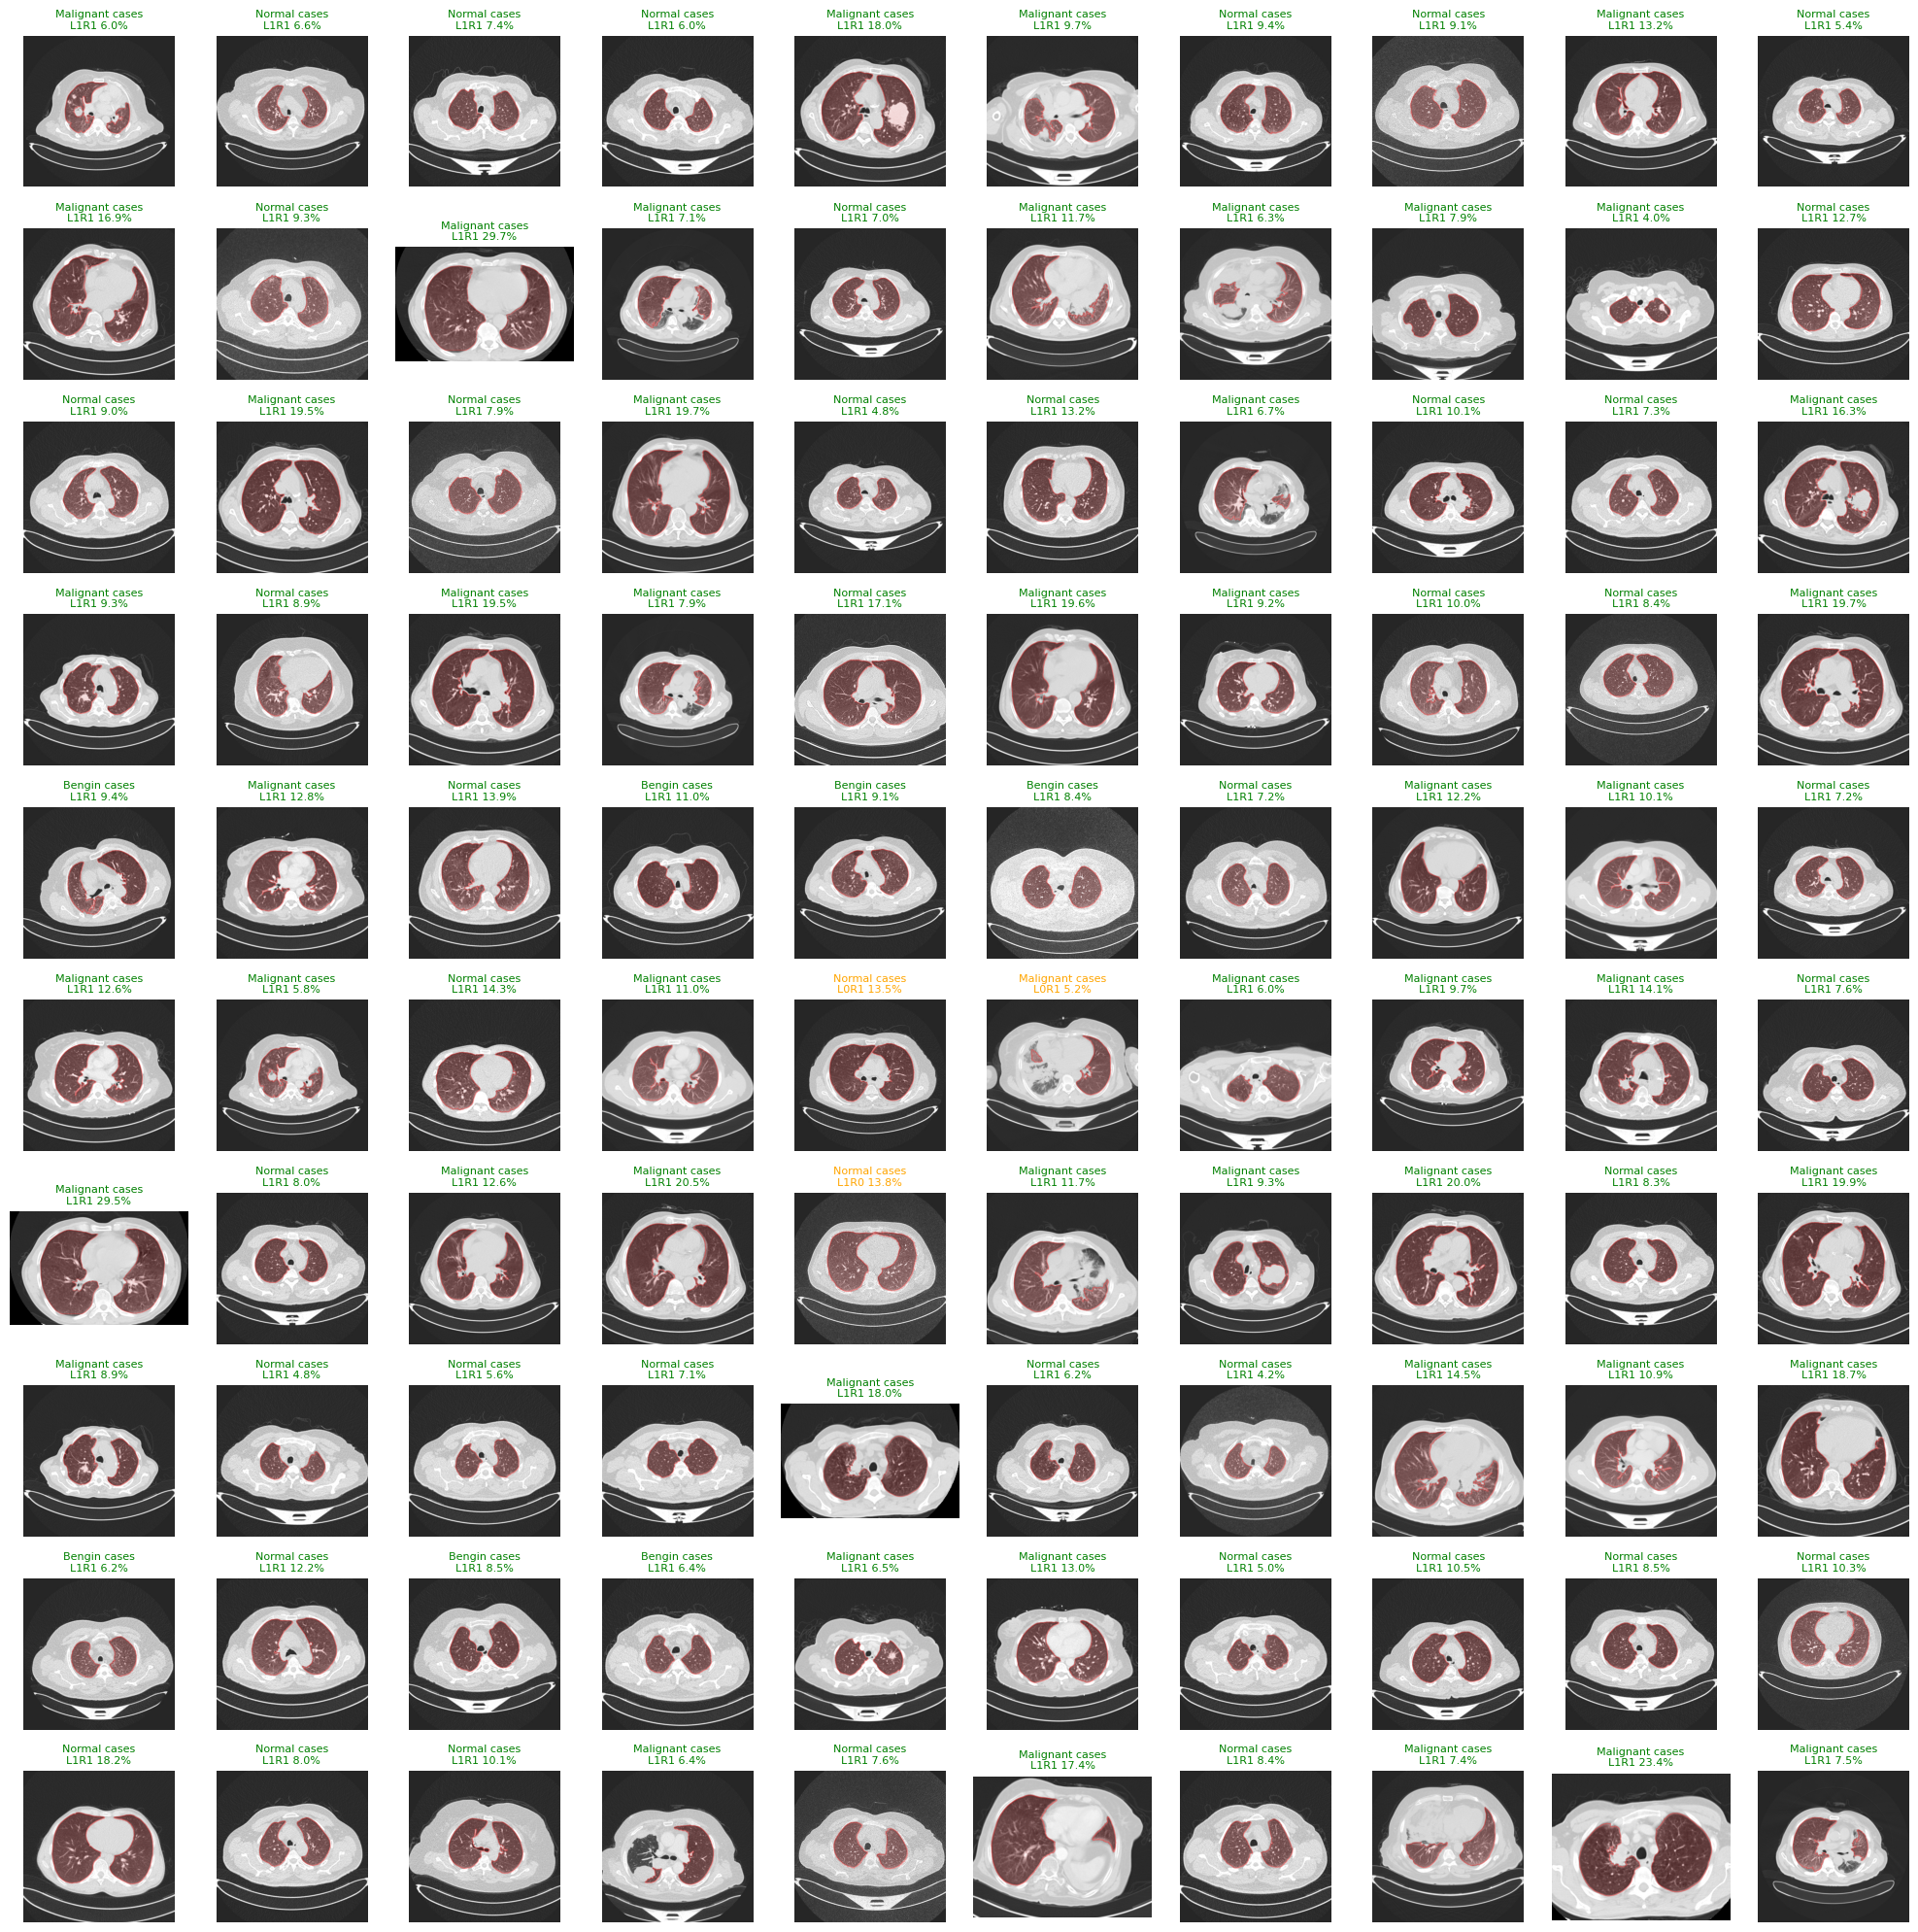


🫁 좌우 폐 검출 통계 (전체 488개):
   좌우 모두: 468개 (95.9%)
   왼쪽만: 13개 (2.7%)
   오른쪽만: 7개 (1.4%)
   검출 실패: 0개 (0.0%)


In [31]:
results = test_images(500,show_all=True)

In [6]:
save_path = save_all_preprocessed()

 모든 이미지 전처리 및 저장 시작...

 Normal cases 처리 중...
   진행: 50/416 | 성공: 50 | 실패: 0
   진행: 100/416 | 성공: 100 | 실패: 0
   진행: 150/416 | 성공: 149 | 실패: 1
   진행: 200/416 | 성공: 199 | 실패: 1
   진행: 250/416 | 성공: 248 | 실패: 2
   진행: 300/416 | 성공: 297 | 실패: 3
   진행: 350/416 | 성공: 345 | 실패: 5
   진행: 400/416 | 성공: 394 | 실패: 6
 Normal cases 완료: 성공 410개, 실패 6개

 Bengin cases 처리 중...
   진행: 50/120 | 성공: 49 | 실패: 1
   진행: 100/120 | 성공: 99 | 실패: 1
 Bengin cases 완료: 성공 119개, 실패 1개

 Malignant cases 처리 중...
   진행: 50/561 | 성공: 46 | 실패: 4
   진행: 100/561 | 성공: 94 | 실패: 6
   진행: 150/561 | 성공: 143 | 실패: 7
   진행: 200/561 | 성공: 191 | 실패: 9
   진행: 250/561 | 성공: 239 | 실패: 11
   진행: 300/561 | 성공: 288 | 실패: 12
   진행: 350/561 | 성공: 333 | 실패: 17
   진행: 400/561 | 성공: 381 | 실패: 19
   진행: 450/561 | 성공: 429 | 실패: 21
   진행: 500/561 | 성공: 475 | 실패: 25
   진행: 550/561 | 성공: 524 | 실패: 26
 Malignant cases 완료: 성공 535개, 실패 26개

🎉 전체 전처리 완료!
   총 성공: 1064개
   총 실패: 33개
   성공률: 97.0%
   저장 위치: /content/lung_preprocessing_results


In [9]:
# prompt: /content/lung_preprocessing_results 폴더를 압축하는 코드 작성

# /content/lung_preprocessing_results 폴더를 압축합니다.
output_filename = '/content/lung_preprocessing_results' # 압축 파일 이름 (확장자 제외)
shutil.make_archive(output_filename, 'zip', save_path)

print(f"\n {save_path} 폴더가 {output_filename}.zip 으로 압축되었습니다.")



 /content/lung_preprocessing_results 폴더가 /content/lung_preprocessing_results.zip 으로 압축되었습니다.


# 트레이닝

In [1]:
# -----------------------------------------------
# 🔧 FocusNet-LC 전체 파이프라인 (Step 1~9 통합 정리)
# -----------------------------------------------

# Step 1️: 라이브러리 불러오기
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization


# Step 2️: 기본 설정 (수동 zip 업로드 방식)
from google.colab import files


# 경로 설정
base_path = "/content/lung_preprocessing_results"
print("압축 풀린 경로 내부 폴더들:", os.listdir(base_path))

# 클래스별 이미지 개수 확인
for folder_name in ["Normal cases", "Bengin cases", "Malignant cases"]:
    full_path = os.path.join(base_path, folder_name)
    full_path = os.path.join(full_path, "processed")
    print(f" {folder_name}: {full_path}")
    image_files = glob(os.path.join(full_path, "*.png"))
    print(f" {folder_name}: {len(image_files)} images")

압축 풀린 경로 내부 폴더들: ['Normal cases', 'Malignant cases', 'Bengin cases']
 Normal cases: /content/lung_preprocessing_results/Normal cases/processed
 Normal cases: 410 images
 Bengin cases: /content/lung_preprocessing_results/Bengin cases/processed
 Bengin cases: 119 images
 Malignant cases: /content/lung_preprocessing_results/Malignant cases/processed
 Malignant cases: 535 images


In [4]:

IMG_SIZE = 512

# Step 3️: 폐 ROI 마스크 생성 함수 (논문 Figure 5 기반)
# 이 함수는 CT 이미지에서 폐 부위만 남기기 위한 마스크를 생성합니다.
# Threshold는 0.3 이상인 픽셀을 폐 조직으로 간주하여 선택합니다.
# 이 값은 CT 영상에서 폐가 주변보다 상대적으로 밝은 회색 계열에 위치하므로 설정됩니다.
# 이후 연결 성분 분석을 통해 작은 노이즈(blobs)를 제거합니다.
# Morphological Closing 연산을 두 번 사용해 폐 내부의 작은 구멍들을 메우고 폐 형태를 부드럽게 만듭니다.



# Step 5️: 전처리2 - 폐 영역만 남기기 (Remove blobs → ROI 추출 → Fill holes)
def segment_lung_mask_refined(img):
    _, binary = cv2.threshold(img, 0.4, 1.0, cv2.THRESH_BINARY_INV)  # threshold ↑
    binary = binary.astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    sizes = stats[1:, -1]
    min_size = 1000  # 더 작은 블롭 제거
    clean_mask = np.zeros_like(binary)
    for i, size in enumerate(sizes):
        if size >= min_size:
            clean_mask[labels == i + 1] = 1
    closed = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, np.ones((11, 11), np.uint8))  # 커널 키움
    filled = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    return filled


# Step 6️: 전처리3 - 최종 전처리 적용 함수 (흑백화 + 정규화 + 마스크 적용)
# 두 가지 마스크 방식 비교를 위한 분기 처리 추가
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # CT는 흑백이므로 1채널로 읽기
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # 논문 기준 크기 맞추기
    img = img / 255.0  # intensity scaling (논문 Block 1)

    # 선택한 방식에 따라 다른 마스크 생성 함수 적용
    #//mask = segment_lung_mask_refined(img)

    return img #* mask  # 마스크 적용하여 폐 영역만 남김

# Step 5️: 데이터 로딩 함수 (이미지 + 라벨 + 메타데이터)
def load_data_with_preprocessing(preprocess_fn):
    label_dict = {'Normal cases': 0, 'Bengin cases': 1, 'Malignant cases': 2}
    images, labels, meta = [], [], []
    for label_name, label_val in label_dict.items():
        folder_path = os.path.join(base_path, label_name)
        folder_path = os.path.join(folder_path, "processed")
        image_paths = glob(os.path.join(folder_path, '*.png'))
        for path in image_paths:
            img = preprocess_fn(path)
            if img is None:
                continue
            images.append(img)
            labels.append(label_val)
            age = 0.1 #np.random.randint(50, 81) / 100
            gender = 0.1 # np.random.randint(0, 2)
            meta.append([age, gender])
    X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = to_categorical(labels, num_classes=3)
    meta = np.array(meta)
    return X, y, meta

# Step 6️: 모델 정의 함수
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3),strides=2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=img_input, outputs=output)
    model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 7️: Grad-CAM 히트맵 생성 함수
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    preds = model.predict(img_array)
    pred_index = tf.argmax(preds[0])
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Step 8️: Grad-CAM 시각화 함수
def show_gradcam(img, heatmap, alpha=0.5):
    img = img[0].squeeze()
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3]
    superimposed_img = heatmap_colored * alpha + np.stack([img]*3, axis=-1)
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()

In [ ]:
# Step 9️: 전체 실행 (전처리 → 학습 → 평가 → Grad-CAM)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,  # 좌우반전
    vertical_flip=False,    # 상하반전
    rotation_range=5,     # 회전 증강
    zoom_range=0.1         # 확대/축소
)
val_datagen = ImageDataGenerator()


epoch = 50
batch_size =16


# 데이터 로드 및 분할
X, y, meta = load_data_with_preprocessing(preprocess_image)
X_train, X_temp, y_train, y_temp, meta_train, meta_temp = train_test_split(X, y, meta, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test, meta_val, meta_test = train_test_split(X_temp, y_temp, meta_temp, test_size=0.5, stratify=y_temp, random_state=42)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)



# 모델 생성
model = build_model()

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # 검증 정확도 모니터링
    patience=10,                    # 7 에포크 동안 개선 없으면 중단
    restore_best_weights=True,     # 최고 성능 모델로 복원
    verbose=1                      # 중단 메시지 출력
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',      # 모니터할 지표
    factor=0.8,              # 학습률을 줄이는 비율 (lr * factor)
    patience=5,              # 성능이 개선되지 않아도 기다리는 epoch 수
    min_lr=1e-6,             # 최소 학습률
    verbose=1,                # 로그 출력 여부
    min_delta=1e-3,
)

# 모델 학습 (EarlyStopping 추가)
print(" Starting training with EarlyStopping...")
history = model.fit(
    train_generator,                           #  증강된 훈련 데이터
    validation_data=val_generator,             #  검증 데이터 (증강 없음)
    epochs=epoch,
    callbacks=[early_stopping , reduce_lr], #  두 콜백 모두 추가
    verbose=1
)

print(f"\n Training completed!")
print(f" Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f" Training stopped at epoch: {len(history.history['loss'])}")

 Starting training with EarlyStopping...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.5001 - loss: 1.0304 - val_accuracy: 0.5750 - val_loss: 0.9090 - learning_rate: 1.0000e-04
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.5483 - loss: 0.9279 - val_accuracy: 0.6500 - val_loss: 0.8970 - learning_rate: 1.0000e-04
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 441ms/step - accuracy: 0.6198 - loss: 0.8871 - val_accuracy: 0.6438 - val_loss: 0.8144 - learning_rate: 1.0000e-04
Epoch 4/50
13/47 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.6099 - loss: 0.8893


✅ Test Accuracy: 96.27 %
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        62
           1       0.93      0.72      0.81        18
           2       1.00      0.99      0.99        81

    accuracy                           0.96       161
   macro avg       0.95      0.90      0.92       161
weighted avg       0.96      0.96      0.96       161


📊 Confusion Matrix:
[[62  0  0]
 [ 5 13  0]
 [ 0  1 80]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_495', 'keras_tensor_509']]
Received: inputs=['Tensor(shape=(1, 512, 512, 1))', 'Tensor(shape=(1, 2))']
  warnings.warn(msg)


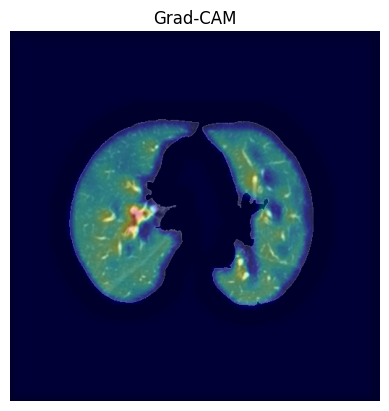

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


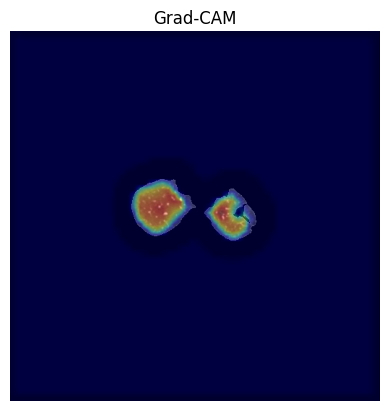

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print("\n✅ Test Accuracy:", round(acc * 100, 2), "%")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred))
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

last_conv_layer = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-3]
heatmap = make_gradcam_heatmap(X_test[0:1], model, last_conv_layer)
show_gradcam(X_test[0:1], heatmap)

heatmap = make_gradcam_heatmap(X_test[10:11], model, last_conv_layer)
show_gradcam(X_test[10:11], heatmap)

In [ ]:
 model.save("lung_model.h5")

In [ ]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 512, 512,  │        640 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_48[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 128, 128,  │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_31… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_50[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 64, 64,    │          0 │ conv2d_51[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_32… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_52[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 32, 32,    │          0 │ conv2d_53[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_33… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_54[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 16, 16,    │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_34… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_56[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 8, 8,      │          0 │ conv2d_57[0][0]   │
│ (MaxPooling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 65536)     │          0 │ max_pooling2d_35

 Total params: 106,982,603 (408.11 MB)

 Trainable params: 35,660,867 (136.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,321,736 (272.07 MB)